In [1]:
import numpy as np
import pandas as pd

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

In [3]:
import sncosmo
import analyzeSN as ans
import opsimsummary as oss

In [4]:
from lsst.sims.catUtils.supernovae import SNObject
from lsst.sims.photUtils import BandpassDict

In [5]:
from varsim import BasePopulation, BasicSimulation, BaseModel

In [6]:
from astropy.cosmology import Planck15 as cosmo

In [7]:
opsout = oss.OpSimOutput.fromOpSimDB('/Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db')

 reading from database sqlite:////Users/rbiswas/data/LSST/OpSimData/minion_1016_sqlite.db
SELECT * FROM Summary WHERE PROPID in (56, 54)


/Users/rbiswas/soft/LSST/DarwinX86/miniconda2/4.2.12.lsst1/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [8]:
pointings = opsout.summary.query('fieldID == 1447')
ddfpointings = opsout.summary.query('fieldID == 1427')

## Define the light curves of EM counterparts to GW 

In [9]:
# Data dir from Ulrich Feindt's repository
data_dir = '/Users/rbiswas/doc/projects/macronovae-rosswog/data/'

In [10]:
class GWModel(BaseModel):
    def __init__(self, cosmo):
        self.t0 = None
        self.f = None
        self._maxday = None
        self._minday = None
        self.z = None
        self.source = None
        self.gwmodel = None
        self.amp = None
        self.cosmo = cosmo
        
    def setModelParameters(self, params):
        
        self.t0 = params['t0']
        self._maxday = params['maxDay'] 
        self._minday = params['minDay']
        self.z = params['z']
        self.ModelName = params['name']
        self.rpeak = params['rpeak']
        phase, wave, flux = sncosmo.read_griddata_ascii(data_dir + '/' + self.ModelName)
        self.source = sncosmo.TimeSeriesSource(phase, wave, flux, zero_before=0.)
        sourcepeak = self.source.peakmag('lsstr', 'ab', sampling=0.1)
        dl = cosmo.luminosity_distance(params['z']).value
        r = dl / 1.0e-5
        amp = self._getAmp(self.rpeak, sourcepeak) 
        amp = amp / r / r
        self.gwmodel = sncosmo.Model(source=self.source)
        self.amp = amp
        print(amp)
        self.gwmodel.set(**dict(t0=self.t0, amplitude=amp))
        return
    
    @property
    def minMjd(self):
        return self._minMjd
    
    @property
    def maxMjd(self):
        return self._maxday + self.t0
    
    @property
    def minMjd(self):
        return self._minday + self.t0
    
    def _getAmp(self, rpeak, magfound):
        return 10.0**(-0.4*(rpeak - magfound))
    
    def modelFlux(self, mjd, bandpassobj):#, filtername=None):
        #d = mjd[(mjd > self.minMjd) & (mjd < self.maxMjd)]
        #bandpassname = bandpassobj.bandpassname[-5]
        #vals = self.gwmodel.bandflux('lsst' + bandpassname, time=mjd, zp=0, zpsys='ab')
        vals = self.gwmodel.bandflux(bandpassobj, time=mjd, zp=0, zpsys='ab')
        return max(vals, 0)

In [11]:
# This is how I would like to define a population. For what we are doing this is overkill, but this is what I would 
# like to define 
class GWPopulation(BasePopulation):
    def __init__(self):
        self.t0 = [59853., 59852.05, 59840]
        self.maxDay = [50., 50., 30]
        self.minDay = [0.00, 0.00, 0.]
        self.z = [0.04, 0.02, 0.02]
        self.name = ['SED_FRDM_NSBH3.dat', 'SED_ns12ns12_kappa10.dat', 'SED_ns12ns12_kappa10.dat']
        self.rpeak = [-11.4, -11.2, -11.2]
        
    def modelparams(self, idx):
        return dict(t0=self.t0[idx], maxDay=self.maxDay[idx], minDay=self.minDay[idx], z=self.z[idx],
                    name=self.name[idx], rpeak=self.rpeak[idx])
    @property
    def idxvalues(self):
        return (x for x in (0, 1))
    @property
    def numSources(self):
        return sum(1 for i in self.idxvalues)

In [12]:
gwpop = GWPopulation()

In [13]:
# Each member of a population has a set of params
gwpop.modelparams(0)

{'maxDay': 50.0,
 'minDay': 0.0,
 'name': 'SED_FRDM_NSBH3.dat',
 'rpeak': -11.4,
 't0': 59853.0,
 'z': 0.04}

In [14]:
# This is a stop gap measure. We won't need to define this (will happen automatically)
def modellc(model, pointings, rng=np.random.RandomState(0), idx=0):
    bandpassdict = BandpassDict.loadTotalBandpassesFromFiles()
    maxMJD = model.maxMjd
    minMJD = model.minMjd
    df = pointings.query('expMJD < @maxMJD and expMJD > @minMJD').copy()
    sn = SNObject(ra=0., dec=0.)
    numObs = len(df)
    mFlux = np.zeros(len(df))
    fluxerr = np.zeros(len(df))
    
    for i, rowtuples in enumerate(df.iterrows()):
        row = rowtuples[1]
        bp = 'lsst' + row['filter']
        mFlux[i] = model.modelFlux(row['expMJD'], bandpassobj=bp)
        fluxerr[i] = sn.catsimBandFluxError(time=row['expMJD'], 
                                            bandpassobject=bandpassdict[row['filter']],
                                            fluxinMaggies=mFlux[i],
                                            m5=row['fiveSigmaDepth'])
    df.reset_index(inplace=True)
    df['objid'] = np.ones(numObs)*np.int(idx)
    df['objid'] = df.objid.astype(np.int)
    df['fluxerr'] = fluxerr
    deviations = rng.normal(size=len(df))
    df['deviations'] = deviations
    df['zp'] = 0.
    df['ModelFlux'] = mFlux
    df['flux'] = df['ModelFlux'] + df['deviations'] * df['fluxerr']
    df['zpsys']= 'ab'
    df['filter'] = df['filter'].apply(lambda x: 'LSST' + x)
    #df['pid'] = self.pair_method(df.objid, df.obsHistID, self.maxObsHistID)
    #df['pid'] = df.pid.astype(np.int)
    lc = df[['obsHistID', 'objid', 'expMJD', 'filter', 'ModelFlux', 'fieldID', 'flux',
                   'fluxerr', 'deviations', 'zp', 'zpsys']]
    return lc    

In [15]:
gw0 = GWModel(cosmo)

In [16]:
gw0.setModelParameters(gwpop.modelparams(0))

2.1117489593e-15


In [17]:
gw0.z

0.04

In [18]:
gw0.t0

59853.0

In [19]:
gw0.amp

2.1117489592978308e-15

In [20]:
-2.5*np.log10(np.array(list(gw0.modelFlux(mjd=t, bandpassobj='lsstr') for t in np.arange(59850, 59880, 0.1)))).max()

/usr/local/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


24.905123624766912

In [21]:
_x = gw0.gwmodel.bandmag('lsstr', 'ab', np.arange(59850, 59880, 0.1))
_x[~np.isnan(_x)].min()

/Users/rbiswas/soft/LSST/DarwinX86/sncosmo/12.0-1-g5e70e90+2/lib/python/sncosmo-1.3.0-py2.7-macosx-10.6-x86_64.egg/sncosmo/models.py:170: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


24.905123624766912

In [22]:
gw1 = GWModel(cosmo)

In [23]:
gw1.setModelParameters(gwpop.modelparams(1))

1.19507423603e-14


### Light Curves

In [24]:
wfdl_0 = modellc(gw0, pointings)
ddfl_0 = modellc(gw0, ddfpointings)
wfdlc_0 = ans.LightCurve(wfdl_0)
ddflc_0 = ans.LightCurve(ddfl_0)

/Users/rbiswas/soft/LSST/DarwinX86/sims_catUtils/2.3.4.sims/python/lsst/sims/catUtils/supernovae/snObject.py:736: RuntimeWarning: divide by zero encountered in log10
  return -2.5 * np.log10(fluxinMaggies)
/Users/rbiswas/soft/LSST/DarwinX86/sims_photUtils/2.3.4.sims/python/lsst/sims/photUtils/SignalToNoise.py:358: RuntimeWarning: divide by zero encountered in double_scalars
  fluxRatio = m5Flux/sourceFlux
/Users/rbiswas/soft/LSST/DarwinX86/sims_catUtils/2.3.4.sims/python/lsst/sims/catUtils/supernovae/snObject.py:780: RuntimeWarning: invalid value encountered in double_scalars
  return fluxinMaggies / SNR


In [25]:
# light curve
wfdlc_0.lightCurve.head()

,obsHistID,objid,mjd,band,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
0,206395,0,59859.331850,LSSTi,1.521559e-11,1447,1.933617e-10,1.009869e-10,1.764052,0.0,ab
1,206328,0,59859.301390,LSSTi,1.552834e-11,1447,6.096041e-11,1.135355e-10,0.400157,0.0,ab
2,206364,0,59859.317719,LSSTi,1.536011e-11,1447,1.157117e-10,1.025316e-10,0.978738,0.0,ab
3,206305,0,59859.290999,LSSTi,1.563608e-11,1447,3.208208e-10,1.361889e-10,2.240893,0.0,ab
4,208053,0,59861.286978,LSSTy,4.301950e-11,1447,6.904816e-10,3.466891e-10,1.867558,0.0,ab


In [26]:
# light curve
ddflc_0.lightCurve.head()

,obsHistID,objid,mjd,band,ModelFlux,fieldID,flux,fluxerr,deviations,zp,zpsys
0,233596,0,59902.081454,LSSTy,0.0,1427,NaN,NaN,-1.454366,0.0,ab
1,233597,0,59902.081871,LSSTy,0.0,1427,NaN,NaN,0.045759,0.0,ab
2,233598,0,59902.082287,LSSTy,0.0,1427,NaN,NaN,-0.187184,0.0,ab
3,233599,0,59902.082704,LSSTy,0.0,1427,NaN,NaN,1.532779,0.0,ab
4,233600,0,59902.083121,LSSTy,0.0,1427,NaN,NaN,1.469359,0.0,ab


In [27]:
ddflc_0.lightCurve.flux.dropna().apply(lambda x: -2.5 *np.log10(x)).describe()

count    490.000000
mean      25.565189
std        1.552974
min       22.342871
25%       24.463262
50%       25.475001
75%       26.491111
max       31.876637
Name: flux, dtype: float64

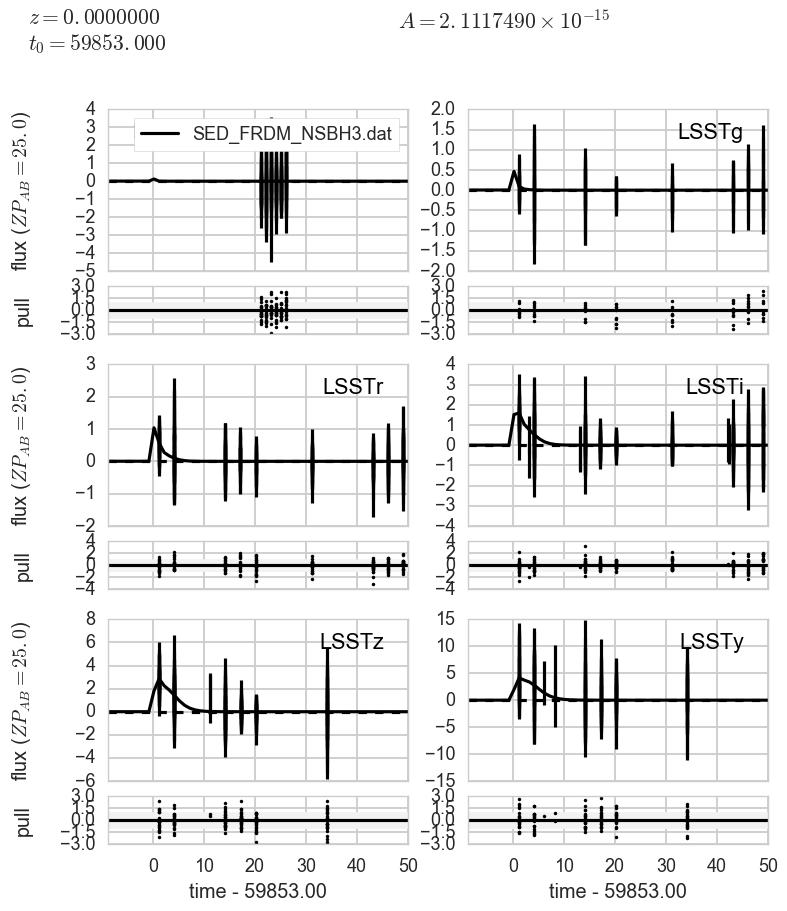

In [69]:
fig_ddf = sncosmo.plot_lc(ddflc_0.snCosmoLC(), color='k',
                          show_model_params=True, model=gw0.gwmodel, model_label=gw0.ModelName)
for axx in fig_ddf.axes:
    axx.set_xlim(xmax=50)
_ = fig_ddf

### Let us clean this up by using a coadded result

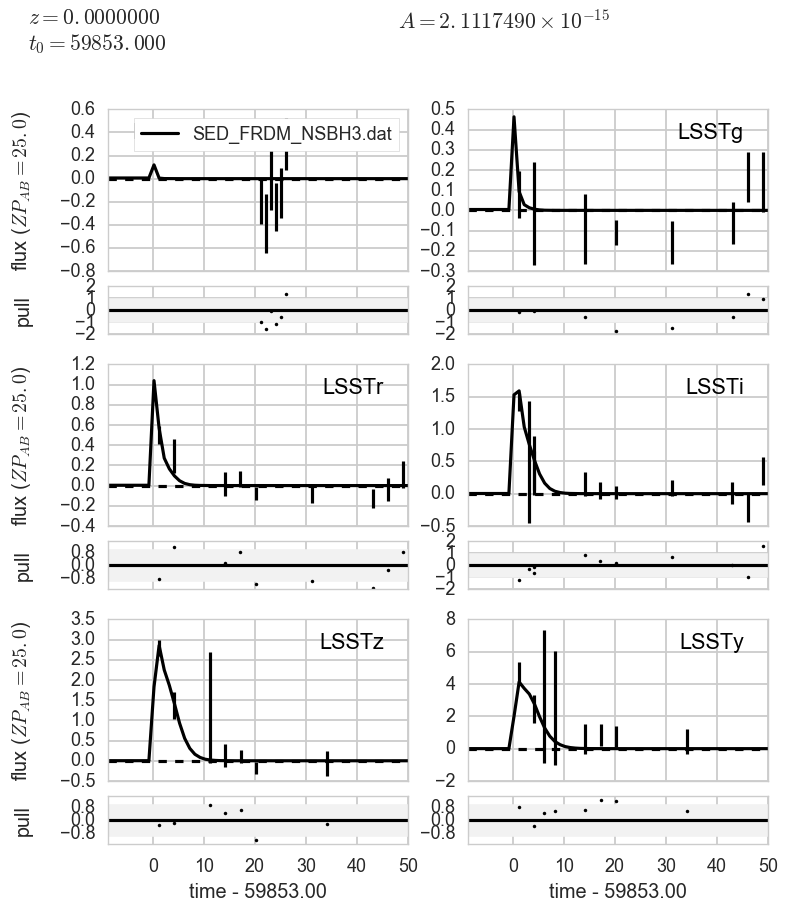

In [68]:
fig_ddf_coadd = sncosmo.plot_lc(ddflc_0.snCosmoLC(coaddTimes=1), color='k',
                                show_model_params=True, model=gw0.gwmodel, model_label=gw0.ModelName)
for axx in fig_ddf_coadd.axes:
    axx.set_xlim(xmax=50)
_ = fig_ddf_coadd

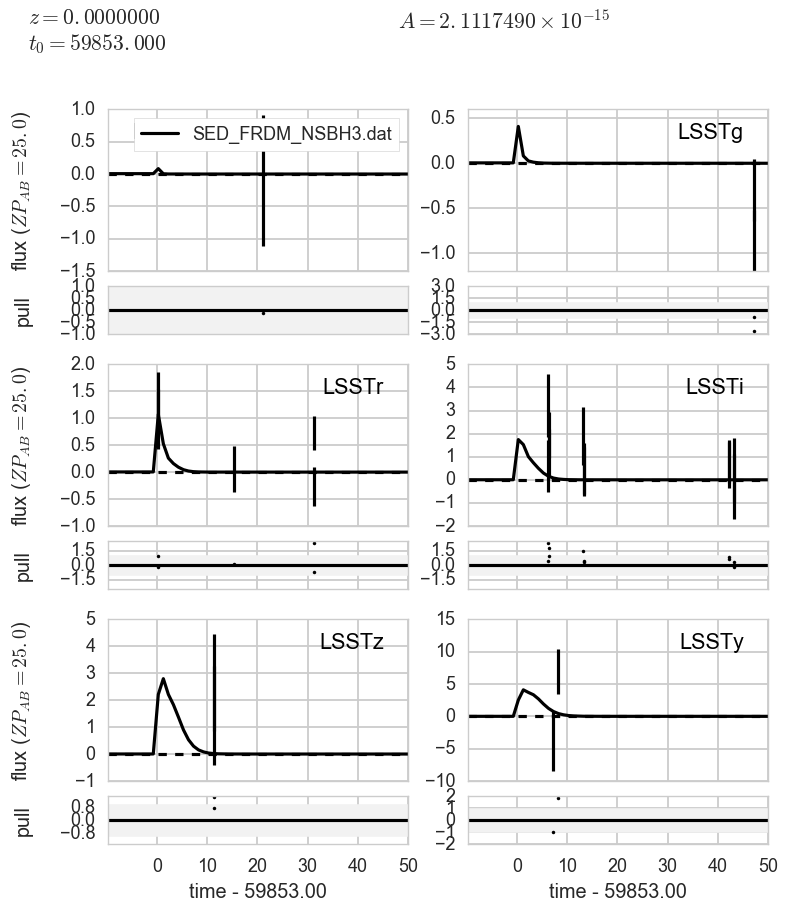

In [67]:
fig_wfd = sncosmo.plot_lc(wfdlc_0.snCosmoLC(), 
                          color='k', model=gw0.gwmodel, model_label=gw0.ModelName)
for axx in fig_wfd.axes:
    axx.set_xlim(xmax=50)
_ = fig_wfd

In [57]:
fig_ddf.savefig('ddf_lc_0.png')
fig_wfd.savefig('wfd_lc_0.png')

In [58]:
wfdl_1 = modellc(gw1, pointings)
ddfl_1 = modellc(gw1, ddfpointings)
wfdlc_1 = ans.LightCurve(wfdl_1)
ddflc_1 = ans.LightCurve(ddfl_1)

In [59]:
gw1.z

0.02

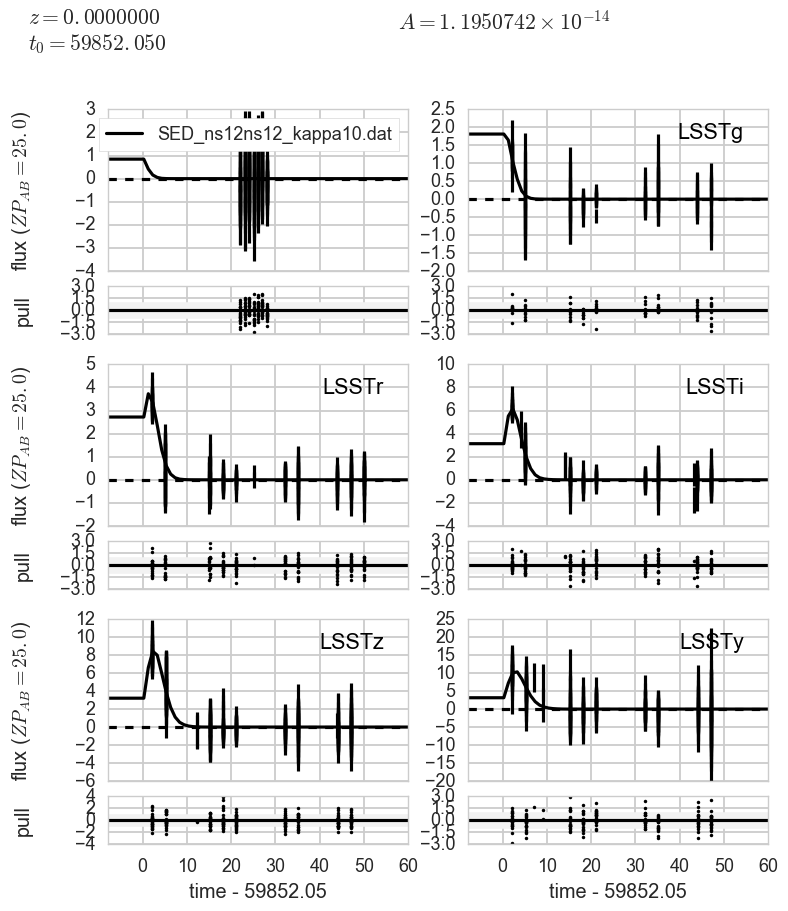

In [66]:
fig_ddf_1 = sncosmo.plot_lc(ddflc_1.snCosmoLC(), color='k', model=gw1.gwmodel, model_label=gw1.ModelName)



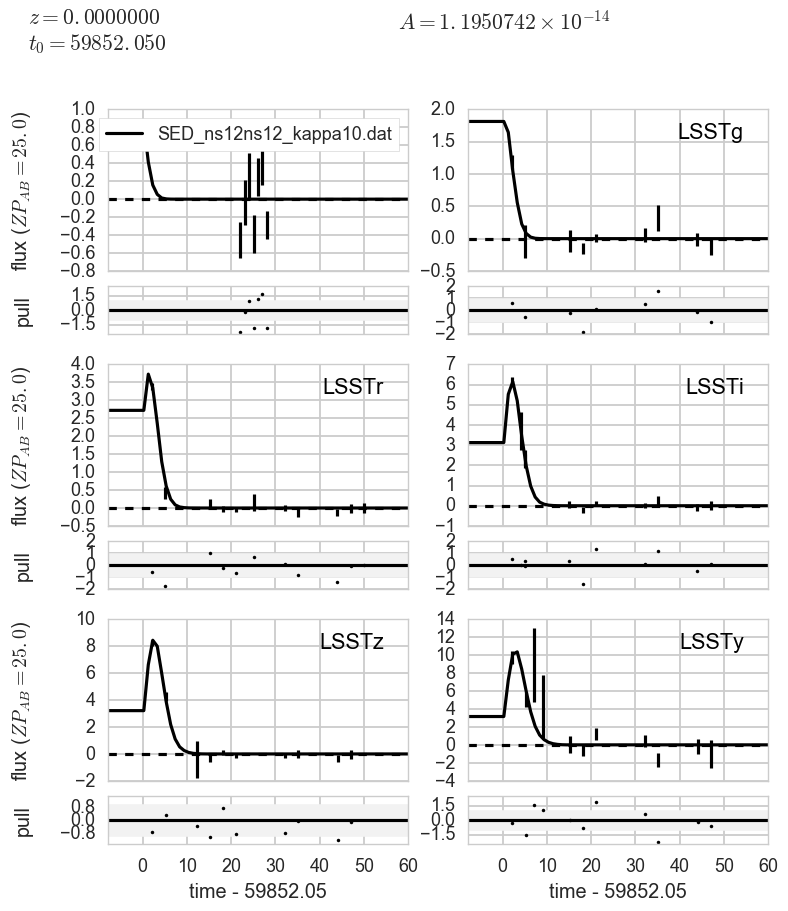

In [65]:
fig_ddf_1_coadd = sncosmo.plot_lc(ddflc_1.snCosmoLC(coaddTimes=1), color='k', model=gw1.gwmodel, model_label=gw1.ModelName)

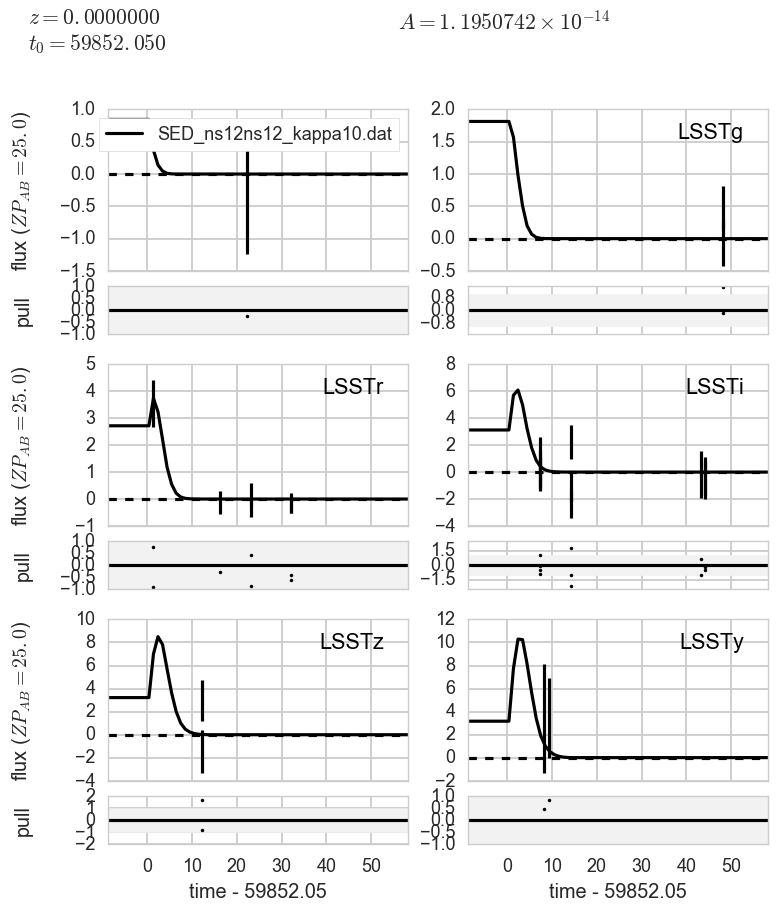

In [64]:
fig_wfd_1 = sncosmo.plot_lc(wfdlc_1.snCosmoLC(), color='k', model=gw1.gwmodel, model_label=gw1.ModelName)

### Sanity Checks

In [92]:
gw0.t0

59853.0

In [93]:
gw0.z

0.1

In [94]:
# r apparent mag peak
-2.5 * np.log10(np.array(list(gw0.modelFlux(t, 'lsstr') for t in np.arange(59853., 59900, 0.1))).max())

26.985168524327413

In [95]:
# Let us neglect the k correction first. 
cosmo.distmod(z=0.1)

<Quantity 38.385007834432244 mag>

In [96]:
-11.4 + 38.4

27.0

## Scratch

In [38]:
gw0.setModelParameters(gwpop.modelparams(0))

3.10902582139e-06


In [40]:
gw0.gwmodel.source_peakabsmag

3.1090258213932801e-06

In [186]:
gw2 = GWModel(cosmo)
gw2.setModelParameters(gwpop.modelparams(2))

1.19507423603e-14


In [41]:
gw0.gwmodel.source_peakabsmag('lsstr','ab', )

inf

In [37]:
gwpop.modelparams(0)

{'maxDay': 50.0,
 'minDay': 0.0,
 'name': 'SED_FRDM_NSBH3.dat',
 'rpeak': -11.4,
 't0': 59853.0,
 'z': 0.1}

In [99]:
gw.amp

0.70246948398575948

In [108]:
x = -2.5 * np.log10(ddflc.lightCurve.query('ModelFlux > 0.').ModelFlux.dropna())

In [115]:
min(x)

-12.843011982048765

In [111]:
from astropy.cosmology import Planck15 as cosmo

In [114]:
cosmo.distmod(0.1).value -11.4 

26.985007834432245

In [117]:
gw.t0

59853.0

In [121]:
gw.z

0.1

In [178]:
gw.gwmodel.bandmag('lsstr', time=np.arange(59845, 59865, 0.1), magsys='ab').min()

1.9851685243226562

In [179]:
mask = np.isnan(gw.source.bandmag('lsstr', phase=np.arange(-20, 50, 0.1), magsys='ab'))

In [131]:
gw.source.bandmag('lsstr', phase=np.arange(-20, 50, 0.1), magsys='ab')[~mask].min()

-11.783270653161615

In [177]:
cosmo.luminosity_distance(0.1)

<Quantity 475.33694090281324 Mpc>

In [112]:
cosmo.luminosity_distance(0.033)

<Quantity 149.7041875023309 Mpc>